# This jupyter notebook is prepared by Tyler Beach.

# A5 Convolutional Neural Network (Total 150pts)


## 1. Import libraries (Total 6pts)

### 1.1 Import torch, torchvision, torchvision.transforms, torch.utils.data and torch.nn (6pts)

In [ ]:
import torch, torchvision, torchvision.transforms as T, torch.utils.data, torch.nn

## 2. Data Preparation (Total 32pts)


### 2.1 Image Transformation (12pts)
Define a transformation pipeline using torchvision.transforms.Compose.

In the pipeline, use **ColorJitter, GaussianBlur, RandomHorizontalFlip, ToTensor and Normalize** from the transforms library.

For the first four transformations, use suitable parameters of your informed choice. At the end, normalize the images with mean 0.5 and variance 0.5.

Read about these transformations here: https://pytorch.org/vision/0.9/transforms.html

In [ ]:
transforms = T.Compose([
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    T.GaussianBlur(kernel_size=(7,13), sigma=(9,11)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor(),
    T.Normalize(0.5, 0.5)]
)

### 2.2 Prepare train and test set by loading CIFAR10 dataset from torchvision.datasets. (4pts)
Make sure you are using the **transform** pipeline (you just wrote in task #2.1) on both train and test set. 

**Hint:** Preparing train and test sets can be directly achieved by utilizing the class parameters.


Read about CIFAR10 dataset class in PyTorch: https://pytorch.org/vision/0.9/datasets.html#cifar

In [ ]:
trainset = torchvision.datasets.CIFAR10(root = './data', train=True, download=True, transform=transforms)
testset = torchvision.datasets.CIFAR10(root = './data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


### 2.3 Use torch.utils.data.random_split() to make a validation set from the training set with 80:20 split. (3pts)

Make sure the training set you'll use after this point excludes the validation set of images 


In [ ]:
trainset, validationset = torch.utils.data.random_split(trainset, [.8, .2])

### 2.4 Prepare three dataloaders for train, validation and test set. Use an appropriate batchsize of your choice. (1+2+2+2 =7pts)


**Hints:**
1. Remember that choosing a batchsize is always a trade-off between efficiency and generalizability. With large batchsize, your model learns more and better in each forward pass, but each pass will require larger computation. On the other hand, with small batchsize, it might converge quicker, but each forward pass teaches features from a smaller subset, which may not be a good representation of the overall data; leading to jittery convergence.
2. During training, you will use the train and validation set for tracking the loss and avoiding overfitting. The test set will be hold out until you are ready to evaluate a trained model on new data. 

Read about pytorch Dataloaders here:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [ ]:
batch_size = 64

from torch.utils.data import DataLoader
train_dataloader = DataLoader(trainset, batch_size, shuffle=True)

test_dataloader = DataLoader(testset, batch_size, shuffle=True)

validation_dataloader = DataLoader(validationset, batch_size, shuffle=True)


### 2.5 Load a random batch of images from the training set using the trainloader. Then use *make_grid()*  from *torchvision.utils* and *imshow()* from *matplotlib.pyplot* to show the images. Also, print the corresponding true labels for those image samples. (6pts)
Hint: you may need to reshape the *make_grid()* output to comply with the format *imshow()* accepts.

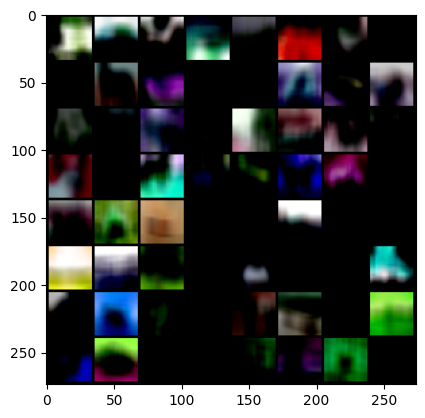

tensor([9, 1, 7, 0, 8, 4, 1, 3, 4, 7, 5, 4, 4, 8, 1, 9, 5, 9, 6, 1, 9, 0, 4, 4,
        3, 2, 7, 1, 0, 7, 6, 1, 8, 6, 0, 6, 2, 0, 6, 8, 8, 8, 6, 1, 5, 2, 9, 9,
        9, 8, 6, 4, 7, 8, 5, 8, 4, 9, 4, 6, 7, 2, 6, 2])


In [ ]:
import matplotlib.pyplot as plt
import random

# TODO: load a random batch of test set images
images, labels = next(iter(train_dataloader))

grid = torchvision.utils.make_grid(images)
grid = grid.permute(1, 2, 0)
plt.imshow(grid)
plt.show()

print(labels)

## 3. Model Design (Total 22pts)

### 3.1 Define a neural network model: (2+7+7 =16pts)
- Name the model class with your first name
- In the following sequential order, the model should consist:

    (1) a 2D convolution layer with 6 filters, dimension of each filter is (5, 5), stride=1, no zero padding
    
    (2) a Max Pool layer with filter size (2, 2), stride=2
    
    (3) a 2D convolution layer with 16 filters, dimension of each filter is (5, 5), stride=1, no zero padding

    (4) a 2D Max Pool layer with filter size (2, 2), stride=2
    
    ~ a flatten layer ~

    (5) a Dense/Fully-connected layer with 120 neurons
    
    ~ a ReLU activation ~
    
    ~ a Dropout Layer ~

    (6) a Dense/Fully-connected layer with 80 neurons
    
    ~ a ReLU activation ~

    (7) a Dense/Fully-connected layer with 10 neurons

Note: 
1. Flatten, ReLU and Dropout are not really "layers". They are operations with specific purpose. But in model construction in pytorch, they are abstracted as layers.
    
    Flatten is used to convert the 4th layer output to a 1D tensor so that it can be passed through the next fully-connected layer. Since each forward pass takes a batch of data, use the *start_dim* parameter of *torch.flatten()* appropriately to keep the batch dimension intact.
    
    ReLU is an activation that transforms the Dense Layer's linear output to a non-linear "active" output.
    
    Dropout is a regularization technique. Read more in slides. In this assignment, you can drop neurons with 50% probability. 

2. This dataset has 10 classes, hence the final layer consists 10 neurons. 

3. The model architecture is similar to the one you saw in in-class Quiz 2, with an extra dense layer in the end. 

    Read about building your custom model in pytorch here: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

    The official pytorch documentation on conv, flatten, rely, dense are also resourceful.


In [ ]:
import torch.nn as nn
import torch.functional as F

class Tyler(nn.Module):
    def __init__(self):
        super(Tyler, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        self.lin2 = nn.Linear(in_features=120, out_features=80)
        self.activation = torch.nn.ReLU()
        self.lin3 = nn.Linear(in_features=80, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mp1(x)
        x = self.conv2(x)
        x = self.mp2(x)
        x = self.flat(x)
        x = self.lin1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.lin2(x)
        x = self.activation(x)
        x = self.lin3(x)
        return x


### 3.2 Create an instance of the model class that you just prepared. (2pts)

In [ ]:
tylermodel = Tyler()

### 3.3 Set up Cross Entropy Loss as the loss function and *Adam* as the optimizer. Use a learning rate of your choice for the optimizer. (4pts) 


In [ ]:
# TODO: Define the loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tylermodel.parameters(), lr=0.001)

for name, param in tylermodel.named_parameters():
    if 'weight' in name:
        print(name, param.size())

conv1.weight torch.Size([6, 3, 5, 5])
conv2.weight torch.Size([16, 6, 5, 5])
lin1.weight torch.Size([120, 400])
lin2.weight torch.Size([80, 120])
lin3.weight torch.Size([10, 80])


## 4. Training and Validation (Total 50pts)


### 4.1 Write a training loop to load data, compute model output, compute loss and backpropagating it to update model parameters. (30pts)

The # TODO tags below contain further instructions. 

In [76]:
import numpy as np
# TODO: Define number of epochs
num_epochs = 20

# TODO: Initialize empty lists to store training loss, training accuracy, validation loss, validation accuracy 
# You will use these lists to plot the loss history.
train_loss_list = []
train_acc_list = []
val_loss_hist = []
val_acc_hist = []
device = torch.device('cpu')

# TODO: Loop through the number of epochs
for epoch in range(num_epochs):
    print("Epoch #" + str(epoch) + ": ")

    # TODO: set model to train mode
    tylermodel.train()

    # TODO: iterate over the training data in batches
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        
        # TODO: get the image inputs and labels from current batch
        images, labels = images.to(device), labels.to(device)
        
        
        # TODO: set the optimizer gradients to zero to avoid accumulation of gradients
        optimizer.zero_grad()

        # TODO: compute the output of the model
        outputs = tylermodel(images)

        # TODO: compute the loss on current batch
        loss = criterion(outputs, labels)
        
        # TODO: backpropagate the loss
        loss.backward()

        # TODO: update the optimizer parameters
        optimizer.step()

        # TODO: update the train loss and accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        train_loss_list.append(loss.item())
        train_acc_list.append(accuracy)

    # TODO: compute the average training loss and accuracy and store in respective arrays
    train_loss = np.mean(train_loss_list[-len(trainset)//64:])
    train_acc = np.mean(train_acc_list[-len(trainset)//64:])

    # TODO: set the model to evaluation mode
    tylermodel.eval()

    # TODO: keeping the gradient computation turned off, loop over batches of data from validation set.
    val_loss_list = []
    val_acc_list = []
    with torch.no_grad():
      for images, labels in train_dataloader:

            # TODO: compute output of the model
            images, labels = images.to(device), labels.to(device)
            outputs = tylermodel(images)

            # TODO: compute the loss
            loss = criterion(outputs, labels)
            val_loss_list.append(loss.item())
            
            # TODO: compute the validation loss and accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)
            val_acc_list.append(accuracy)

    # TODO: compute the average validation loss and accuracy and store in respective lists
    val_loss = np.mean

    # TODO: print the training loss, training accuracy, validation loss and validation accuracy at the end of each epoch
    avg_val_loss = sum(val_loss_list[-len(val_loss_list):])/len(val_loss_list)
    avg_val_accuracy = sum(val_acc_list[-len(val_acc_list):])/len(val_acc_list)

    print("Train Loss: " + str(train_loss))
    print("Train Acc: " + str(train_acc))
    print("Validation Loss: " + str(avg_val_loss))
    print("Validation Acc: " + str(avg_val_accuracy))

    # TODO: save the model parameters once in every 5 epochs
    if epoch == 4:
      iteration4 = ({
          'epoch': epoch,
          'model_state_dict': tylermodel.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_list': train_loss_list,
          'train_acc_list': train_acc_list,
          'val_loss_hist': val_loss_hist,
          'val_acc_hist': val_acc_hist
      })
    
    if epoch == 9:
      iteration9 = ({
          'epoch': epoch,
          'model_state_dict': tylermodel.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_list': train_loss_list,
          'train_acc_list': train_acc_list,
          'val_loss_hist': val_loss_hist,
          'val_acc_hist': val_acc_hist
      })

    if epoch == 14:
      iteration14 = ({
          'epoch': epoch,
          'model_state_dict': tylermodel.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_list': train_loss_list,
          'train_acc_list': train_acc_list,
          'val_loss_hist': val_loss_hist,
          'val_acc_hist': val_acc_hist
      })
    
    if epoch == 19:
      iteration19 = ({
          'epoch': epoch,
          'model_state_dict': tylermodel.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss_list': train_loss_list,
          'train_acc_list': train_acc_list,
          'val_loss_hist': val_loss_hist,
          'val_acc_hist': val_acc_hist
      })


    

Epoch #0: 
Train Loss: 1.5546642374038697
Train Acc: 0.44835
Validation Loss: 1.4338330364227294
Validation Acc: 0.49685
Epoch #1: 
Train Loss: 1.550820976829529
Train Acc: 0.4482
Validation Loss: 1.4327493627548218
Validation Acc: 0.49625
Epoch #2: 
Train Loss: 1.5470437324523927
Train Acc: 0.4507
Validation Loss: 1.4266011724472045
Validation Acc: 0.498125
Epoch #3: 
Train Loss: 1.5464307418823242
Train Acc: 0.44945
Validation Loss: 1.4205171546936035
Validation Acc: 0.501825
Epoch #4: 
Train Loss: 1.5496660387039185
Train Acc: 0.446925
Validation Loss: 1.4178918575286865
Validation Acc: 0.503725
Epoch #5: 
Train Loss: 1.5450023317337036
Train Acc: 0.449625
Validation Loss: 1.4151719175338746
Validation Acc: 0.502775
Epoch #6: 
Train Loss: 1.5391705541610718
Train Acc: 0.45015
Validation Loss: 1.412700071144104
Validation Acc: 0.50525
Epoch #7: 
Train Loss: 1.5390553886413574
Train Acc: 0.452725
Validation Loss: 1.4185579820632934
Validation Acc: 0.500275
Epoch #8: 
Train Loss: 1.536

### 4.2 Plot and compare (5+5 =10pts)
1. training and validation loss over the number of epochs
2. training and validation accuracy over the number of epochs

(Hint: Use plot() from *matplotlib.pyplot*, import it if you haven't already done so.)

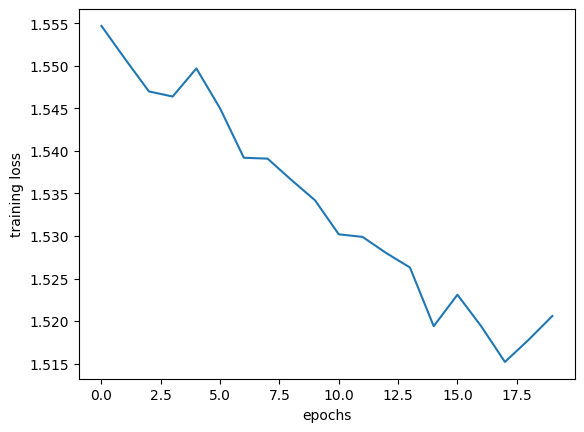

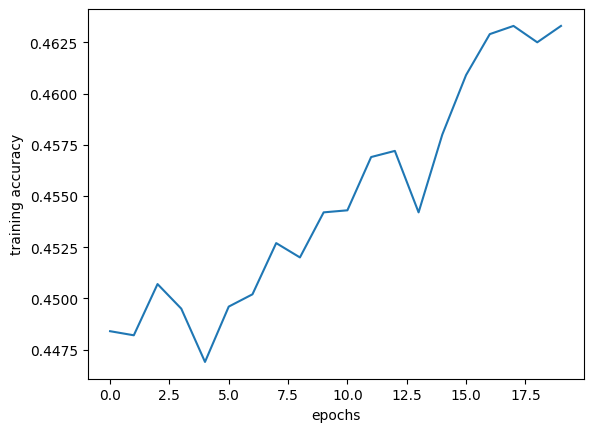

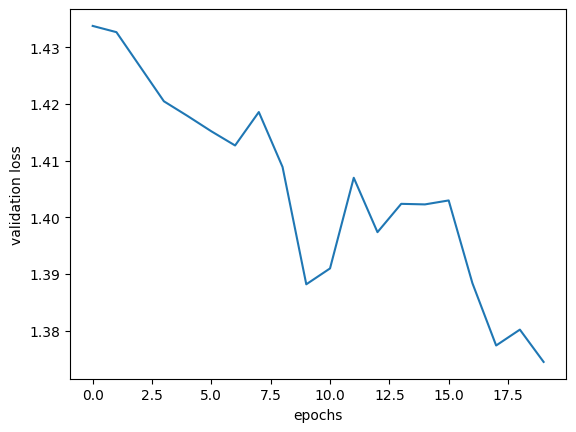

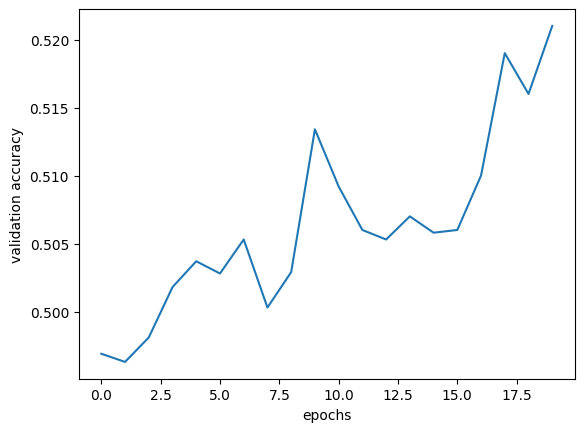

In [77]:
trainloss = [1.5547, 1.5508, 1.547, 1.5464, 1.5497, 1.545, 1.5392, 1.5391, 1.5366, 1.5342, 1.5302, 1.5299, 1.528, 1.5263, 1.5194, 1.5231, 1.5194, 1.5152, 1.5178, 1.5206]
trainacc = [0.4484, 0.4482, 0.4507, 0.4495, 0.4469, 0.4496, 0.4502, 0.4527, 0.452, 0.4542, 0.4543, 0.4569, 0.4572, 0.4542, 0.458, 0.4609, 0.4629, 0.4633, 0.4625, 0.4633]
valloss = [1.4338, 1.4327, 1.4266, 1.4205, 1.4179, 1.4152, 1.4127, 1.4186, 1.4089, 1.3882, 1.391, 1.407, 1.3974, 1.4024, 1.4023, 1.403, 1.3884, 1.3774, 1.3802, 1.3745]
valacc = [0.4969, 0.4963, 0.4981, 0.5018, 0.5037, 0.5028, 0.5053, 0.5003, 0.5029, 0.5134, 0.5092, 0.506, 0.5053, 0.507, 0.5058, 0.506, 0.51, 0.519, 0.516, 0.521]
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

plt.figure(0)
plt.plot(epochs, trainloss)
plt.xlabel("epochs")
plt.ylabel("training loss")

plt.figure(1)
plt.plot(epochs, trainacc)
plt.xlabel("epochs")
plt.ylabel("training accuracy")

plt.figure(2)
plt.plot(epochs, valloss)
plt.xlabel("epochs")
plt.ylabel("validation loss")

plt.figure(3)
plt.plot(epochs, valacc)
plt.xlabel("epochs")
plt.ylabel("validation accuracy")

plt.show()




### 4.3 Discussion: (2*5 = 10pts)
(1) Does the training loss and accuracy improve as number of epoch increases?
**Ultimately, yes. The training loss generally decreased and the training accuracy generally increased over the course of 20 epochs.**

(2) Does the validation loss and accuracy improve as number of epoch increases?
**Yes, for the same reason as with training loss and accuracy. While both training and validation had some spiking and weren't completely flat curves, the loss generally decreased and accuracy generally increased as we went from 0 to 20 epochs.**

(3) Are there any sign of overfitting in the results? If so, when did it start to occur?
**I don't think I see any overfitting, but it is concerning that there's a spike/dip in the validation section around epoch 9.**

(4) How many epochs did it take for the model to converge to a good solution?
**I used 20 epochs and that seemed to be a good number. I noticed in particular that the training accuracy started to get to its best spot around that time.**

(5) What enhancement can be tried to the architecture to further improve the validation performance?
**I wish I had the time/computing power to test it with more epochs. I'm curious to see what would happen if I did it with 40, 50, 100, or even more. I might need a new PC after that, though - step 4.1 took me half an hour with 20 epochs.**

## 5. Testing on new data (Total 40pts)


### 5.1 Load the best performing model (one with good validation accuracy and without overfitting) among the ones you saved. (4pts)

In [79]:
print("Note: Since I only saved every 5th iteration of the model (epochs 4, 9, 14, 19), I have selected the iteration from epoch 19. It has the best validation accuracy and I don't think it's overfitting.")

# TODO: instantiate a model
tylerOptimized = Tyler()
tylerOptimized.load_state_dict(iteration19['model_state_dict'])
optimizer.load_state_dict(iteration19['optimizer_state_dict'])

# TODO: load parameters from one of the saved model states
train_loss_list = iteration19['train_loss_list']
train_acc_list = iteration19['train_acc_list']
val_loss_hist = iteration19['val_loss_hist']
val_acc_hist = iteration19['val_acc_hist']

# TODO: set this model to evaluation mode 
tylerOptimized.eval()


Note: Since I only saved every 5th iteration of the model (epochs 4, 9, 14, 19), I have selected the iteration from epoch 19. It has the best validation accuracy and I don't think it's overfitting.


Tyler(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (lin2): Linear(in_features=120, out_features=80, bias=True)
  (lin3): Linear(in_features=80, out_features=10, bias=True)
)

### 5.2 Take a random batch of images from test set and show the images. Print the corresponding ground truth class labels. Then compute model output (model selected at previous step) and the predicted labels for the images in this batch. (10pts)

This is similar to task #2.5 with additional task on computing model output and printing predicted labels.

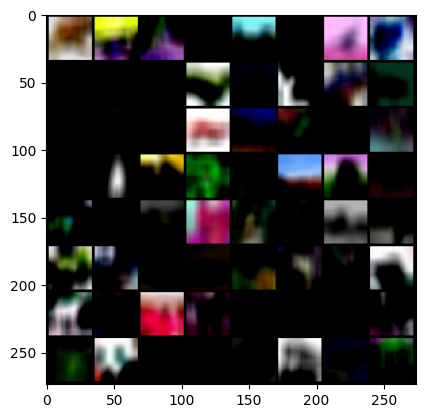

tensor([6, 0, 7, 6, 0, 6, 2, 6, 8, 6, 2, 9, 2, 3, 1, 0, 4, 0, 2, 0, 9, 1, 4, 2,
        8, 5, 9, 2, 4, 0, 9, 7, 9, 6, 8, 5, 2, 6, 9, 3, 9, 3, 9, 0, 4, 2, 4, 8,
        7, 9, 8, 7, 5, 4, 3, 5, 4, 5, 5, 3, 1, 9, 0, 7])
tensor([[ 9.4502e-01, -1.6182e+00,  3.8613e-01,  6.3509e-01, -7.1587e-01,
         -4.1412e-01,  6.4032e-01, -7.6659e-01, -2.2990e+00, -1.4361e+00],
        [ 1.5719e+00,  7.3551e-01, -1.9970e+00, -1.7601e+00, -2.7306e+00,
         -4.0464e+00, -3.1375e+00, -3.0575e+00,  3.3270e+00,  2.3489e+00],
        [-1.5618e+00, -2.5888e+00, -5.3321e-01,  8.8515e-01,  1.5556e+00,
          1.5760e+00, -3.0797e-01,  1.1783e+00, -1.7826e+00, -2.3040e+00],
        [-1.0291e+00, -3.7519e-01, -3.8743e-01, -8.5988e-01,  1.2875e+00,
         -6.0744e-01,  1.6257e-01,  7.9450e-01, -3.0572e+00, -1.3454e+00],
        [ 4.1405e+00,  1.1528e-01, -1.8992e+00, -3.1674e+00, -1.6871e+00,
         -4.8200e+00, -5.5285e+00, -6.0040e-01,  3.1955e+00,  9.6071e-01],
        [-1.5159e+00, -1.7607e+00,  3.

In [83]:
# TODO: load a random batch of test set images
images, labels = next(iter(test_dataloader))
grid = torchvision.utils.make_grid(images)
grid = grid.permute(1, 2, 0)

# TODO: show the images
plt.imshow(grid)
plt.show()

# TODO: print the ground truth class labels for these images
print(labels)

# TODO: compute model output
output = tylerOptimized.forward(images)

# TODO: print the predicted class labels for these images
print(output)


### 5.3 Compute the average accuracy on test data using this model. (4+2 =6pts)
Loop over the test set, compute accuracy on each batch, lastly print the average accuracy. 

In [85]:
# TODO: compute accuracy on each batch of test set
correct = 0
samples = 0
loss = 0

for i, (inputs, labels) in enumerate(test_dataloader):
  outputs = tylerOptimized.forward(inputs)
  loss = criterion(outputs, labels)
  _, predicted = torch.max(outputs.data, 1)
  batch_correct = (predicted == labels).sum().item()

  correct += batch_correct
  samples += labels.size(0)
  loss += loss.item()


# TODO: print the average accuracy
avg_acc = correct/samples
print("Test data average accuracy: " + str(avg_acc))


Test data average accuracy: 0.4794


### 5.4 Compute the average accuracy for each individual class. (8+4 =12pts)
Hint: similar to #5.3. During each loop, log the accuracy for each class separately (a python/numpy dictionary can help). Then print the individual accuracy for the 10 output classes. 

In [88]:
correct = 0
samples = 0
loss = 0
correctCounts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
sampleCounts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, (inputs, labels) in enumerate(test_dataloader):
  outputs = tylerOptimized.forward(inputs)
  loss = criterion(outputs, labels)
  _, predicted = torch.max(outputs.data, 1)
  batch_correct = (predicted == labels).sum().item()

  correct += batch_correct
  samples += labels.size(0)
  loss += loss.item()

  for c in range(10): #because 10 classes
    correctCounts[c] += ((predicted == labels) & (labels == c)).sum().item()
    sampleCounts[c] += (labels == c).sum().item()


# TODO: print the average accuracy
for i in range(10):
  accuracyForThisClass = correctCounts[i]/sampleCounts[i]
  print("Accuracy for label " + str(i) + ": " + str(accuracyForThisClass))


Accuracy for label 0: 0.462
Accuracy for label 1: 0.624
Accuracy for label 2: 0.378
Accuracy for label 3: 0.382
Accuracy for label 4: 0.286
Accuracy for label 5: 0.338
Accuracy for label 6: 0.524
Accuracy for label 7: 0.52
Accuracy for label 8: 0.728
Accuracy for label 9: 0.504


### 5.5 Discussion: (2+2+4 =8pts)
1. Which class of images were detected with highest accuracy? **Class 8 images were detected with the highest accuracy.**
2. Which class of images were hardest for the model to detect? **The model had the most difficulty detecting images of Class 4.**
3. Explain 1-2 possible reasons why detection of some class can be harder for the same model. **One reason that comes to mind is maybe Class 4 images are too similar to images of other classes - because of that, the model may be having trouble identifying what makes a Class 4 image a Class 4 image. Alternatively, it's possible that Class 4 images are indeed distinguishable, but there simply aren't enough Class 4 images for the model to work with and become able to recognize consistently.**